# Interactive notebook for plotting a map undetectible lake size for a given fill-drain amplitude, A, and period t_d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.fft import fft,ifft,fftshift,fftfreq
import matplotlib as mpl
import numpy as np
import scipy
from scipy.io import loadmat
import copy
import xarray as xr
import fsspec
# define some functions
%run Functions.ipynb

## 1. MODEL PARAMETERS
### Change the amplitude  amp and the oscillation period t_pd to see the effect on the maximum observable lake length

In [2]:
amp = 1                                 # oscillation amplitude at base (m)
t_pd = 10*3.154e7                       # oscillation period (s)

delta = 0.1/amp                         # dimensionless displacement threshold corresponding
                                        # to dimensional threshold of 0.1 m

rho = 917.0                             # ice density kg/m^3
g = 9.81                                # gravitational acceleration m^2/s
eta = 1e12                              # constant viscosity (Pa s)

Ls = np.linspace(100,1,101)             # array of lake lengths (relative to ice thickness)
                                        # for computing the minimum detectable lake size
                                        # default minmium value = 1, maximum value = 100.

N_pts = 20                              # number of ice thickness and friction
                                        # values (between max and min values from data)
                                        # for constructing minimum lake size function
                                        # (the total number of computations is N_pts**2)

## 2. LOAD DATA

In [3]:
H_beta_mapper = fsspec.get_mapper('gs://ldeo-glaciology/bedmachine/H_beta.zarr', mode='ab')
H_beta = xr.open_zarr(H_beta_mapper)  # this line loads the 
H_beta.load()
Xv, Yv = np.meshgrid(H_beta.x,H_beta.y)
beta_d = H_beta.beta.data             # (dimensional) friction coefficient (Pa s / m)
H = H_beta.thickness.data 

## 3. COMPUTE MINIMUM DETECTABLE LAKE SIZE AS FUNCTION OF BETA AND H

In [4]:
# construct arrays for H and beta_d that cover the range of the data
H_int = np.linspace(1,np.max(H),N_pts)
beta_int = np.logspace(np.min(np.log10(beta_d)),np.max(np.log10(beta_d)),N_pts)

# array for minimum lake size at every (H,beta_d) value
min_Ls = np.zeros((np.size(H_int),np.size(beta_int)))

print('Computing minimum detectable lake size as function of friction and ice thickness....')

l = 0
for i in range(np.shape(min_Ls)[0]):
    for j in range(np.shape(min_Ls)[1]):
        min_Ls[i,j] = get_min_Ls(Ls,beta_int[i],H_int[j])
        if l % int(np.size(min_Ls)/10.0) == 0:
            print(str(100*l/int(np.size(min_Ls)))+' % complete')
        l+=1
print(str(100*l/int(np.size(min_Ls)))+' % complete')
print('\n')

MLS = interp2d(H_int,beta_int,min_Ls,kind='linear')

Computing minimum detectable lake size as function of friction and ice thickness....
0.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete




## 4. CONSTRUCT THE MAP BY EVALUATING THE FUNCTION


In [5]:
Ls_map = np.zeros(np.shape(beta_d))     # minimum lake length map

print('Constructing map....')
l = 0
for i in range(np.shape(Ls_map)[0]):
    for j in range(np.shape(Ls_map)[1]):
        Ls_map[i,j] = MLS(H[i,j],beta_d[i,j])
        if l % int(np.size(Ls_map)/10.0) == 0:
            print(str(100*l/int(np.size(Ls_map)))+' % complete')
        l+=1
print(str(100*l/int(np.size(Ls_map)))+' % complete')
print('\n')

Constructing map....
0.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete




## 5. Plot maximum undetectible lake length, L_min, ice thickness, H, and friction coefficient, beta

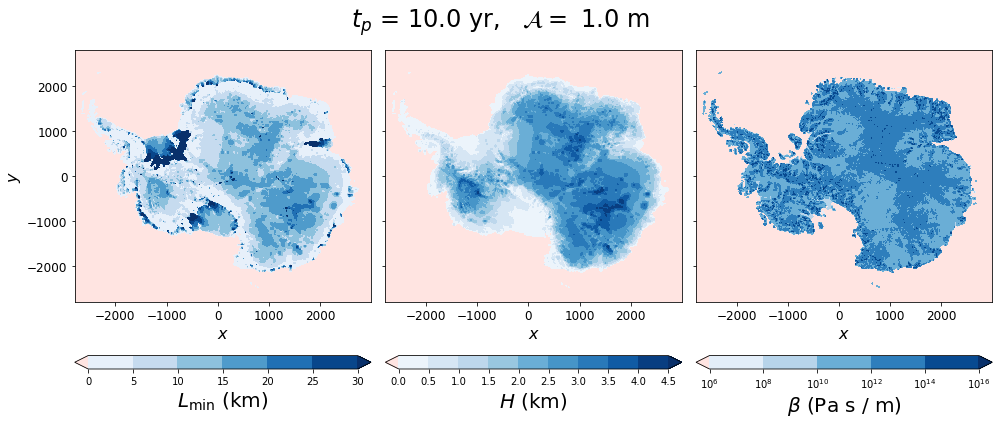

In [6]:
levels_H = np.array([0,500,1000,1500,2000,2500,3000,3500,4000,4500])/1000.0
levels_beta = np.array([1e6,1e8,1e10,1e12,1e14,1e16])

levels_L = np.array([0,5,10,15,20,25,30])


cmap1 = copy.copy(mpl.cm.get_cmap("Blues"))
cmap1.set_under('mistyrose')

plt.figure(figsize=(14,6))
plt.suptitle(r'$t_p$ = '+"{:.1f}".format(t_pd/3.154e7)+r' yr,   $\mathcal{A} =$ '+"{:.1f}".format(amp)+' m',fontsize=24)
plt.subplot(131)
p1 = plt.contourf(Xv/1000,Yv/1000,Ls_map*H/1000.0,cmap=cmap1,levels=levels_L,extend='both')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$y$',fontsize=16)
cbar = plt.colorbar(p1,orientation='horizontal')
cbar.set_label(r'$L_\mathrm{min}$ (km)',fontsize=20)


plt.subplot(132)
plt.xticks(fontsize=12)
plt.gca().yaxis.set_ticklabels([])
plt.xlabel(r'$x$',fontsize=16)
p1 = plt.contourf(Xv/1000,Yv/1000,H/1000.0,cmap=cmap1,levels=levels_H,extend='both')
cbar = plt.colorbar(p1,orientation='horizontal')
cbar.set_label(r'$H$ (km)',fontsize=20)

plt.subplot(133)
plt.xticks(fontsize=12)
plt.xlabel(r'$x$',fontsize=16)
plt.gca().yaxis.set_ticklabels([])
p2 = plt.contourf(Xv/1000,Yv/1000,beta_d,cmap=cmap1,levels=levels_beta,norm=mpl.colors.LogNorm(),extend='both')
cbar = plt.colorbar(p2,orientation='horizontal')
cbar.set_label(r'$\beta$ (Pa s / m)',fontsize=20)

plt.tight_layout()
#plt.savefig('maps')
#plt.close()